# Objective

To reduce the number of dimensions of the Amazon food reviews dataset so that we can visualize it using a scatterplot. The plot should ideally distinguish between positive and negative reviews.

I'm not building a classification model here. The goal is to apply t-SNE on various vector representation of the text data. I will use these models to vectorize text:


*   Bag of Words (Unigram and Bigram)
* Tfidf
* Doc2Vec
* Average W2V
* Tfidf weighted W2V



As always, let's start by loading the files that we need. I'm working on Google Colab for this Exercise, since my laptop isn't powerful enough to handle the workload.

To avoid having to upload data from local disk everytime the environment is disconnected, I'll be using Google Drive to store all the data and pickled models.

In [0]:
from google.colab import drive
drive.mount('/gdrive')

List files on the drive.

In [0]:
# # List all files present on google drive
# import os
# os.listdir('/gdrive/My Drive')

Import needed libraries

In [0]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import nltk
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, roc_curve, auc
from nltk.stem.porter import PorterStemmer

The raw data is present in the form of a sqlite file. Let's retrieve it from google drive.

In [0]:
# load sqlite database
con = sqlite3.connect(r'/gdrive/My Drive/amazon/database.sqlite')

Since the aim here is to just visualize the positive and negative reviews, I select only the reviews that aren't neutral. It's a fair assumption that the reviews with score = 3 are neutral. We'll work with reviews that have score either 1,2,4 or 5.

In [0]:
df = pd.read_sql_query("select * from reviews where score <> 3;", con)

There are about half a million reviews in the original data file that are not neautral.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
Id                        525814 non-null int64
ProductId                 525814 non-null object
UserId                    525814 non-null object
ProfileName               525814 non-null object
HelpfulnessNumerator      525814 non-null int64
HelpfulnessDenominator    525814 non-null int64
Score                     525814 non-null int64
Time                      525814 non-null int64
Summary                   525814 non-null object
Text                      525814 non-null object
dtypes: int64(5), object(5)
memory usage: 40.1+ MB


For this exercise, we want score to be a categorical feature.
* Mark reviews with rating > 3 as positive
* Mark reviews with rating < 3 as negative

In [0]:
m1 =  df['Score'] > 3 
m2 =  df['Score'] < 3 

df['Score'] = np.select([m1,m2], ['positive','negative'])

This is an imbalanced dataset. The number of positice reviews is almost 6 times the number of negative reviews!

In [9]:
df.Score.value_counts()

positive    443777
negative     82037
Name: Score, dtype: int64

Let's change the datatype of Score in our Pandas dataframe to 'Category'. Using Categories instead of the default 'Object' datatype leads to performance improvement.

In [10]:
df['Score']=df['Score'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
Id                        525814 non-null int64
ProductId                 525814 non-null object
UserId                    525814 non-null object
ProfileName               525814 non-null object
HelpfulnessNumerator      525814 non-null int64
HelpfulnessDenominator    525814 non-null int64
Score                     525814 non-null category
Time                      525814 non-null int64
Summary                   525814 non-null object
Text                      525814 non-null object
dtypes: category(1), int64(4), object(5)
memory usage: 36.6+ MB


In [11]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Are there any duplicate rows in the dataset?
Inspecting the "Text" column, we clearly see there are duplicates.

In [13]:
df.duplicated('Text').value_counts()

False    363836
True     161978
dtype: int64

There are also a few anomalies in the data where the HelpfulnessNumerator is greater than the helpfulnessDenominator. 

* HelpfulnessNumberator = Number of positive reviews
* HelpfulnessDenominator = Number of positive reviews + Number of negative reviews

Therefore, HelpfulnessDenominator can't be less than HelpfulnessNumerator.  We need to get rid of such erroneous records.

In [12]:
df[df['HelpfulnessNumerator'] > df['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,positive,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,positive,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


Let's drop these data points using the drop() method given by pandas.

In [0]:
df.drop(df[df['HelpfulnessNumerator'] > df['HelpfulnessDenominator']].index.tolist(), axis=0, inplace=True)

Verify whether the rows have been dropped.

In [15]:
df [df['HelpfulnessNumerator'] > df['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525812 entries, 0 to 525813
Data columns (total 10 columns):
Id                        525812 non-null int64
ProductId                 525812 non-null object
UserId                    525812 non-null object
ProfileName               525812 non-null object
HelpfulnessNumerator      525812 non-null int64
HelpfulnessDenominator    525812 non-null int64
Score                     525812 non-null category
Time                      525812 non-null int64
Summary                   525812 non-null object
Text                      525812 non-null object
dtypes: category(1), int64(4), object(5)
memory usage: 40.6+ MB


Now, let's drop the reviews which have the same data for the attributes:
* UserId
* ProfileName
* Time
* Text

These are the reviews for same products, duplicated in the dataset because Amazon considers slight variations of the same product to be different products. i.e. A food item with red color would be different than the same item of green color. We need to drop these.

In [0]:
df.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep = 'first', inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364171 entries, 0 to 525813
Data columns (total 10 columns):
Id                        364171 non-null int64
ProductId                 364171 non-null object
UserId                    364171 non-null object
ProfileName               364171 non-null object
HelpfulnessNumerator      364171 non-null int64
HelpfulnessDenominator    364171 non-null int64
Score                     364171 non-null category
Time                      364171 non-null int64
Summary                   364171 non-null object
Text                      364171 non-null object
dtypes: category(1), int64(4), object(5)
memory usage: 28.1+ MB


Dropping the duplicate significantly reduces the size of our dataframe.

In [21]:
df.shape

(364171, 10)

### Text Cleaning

Data collected from the web often contains unrendered HTML tags in them. Let's see if our reviews have them. We are only interested in the 'Text' column, because this is the column that will help us decide if a review is positive or negative. 

In [0]:
import re

i=0

for review in df['Text'].values:
    if (len(re.findall('<.*>', review))):
            i+=1
            r=review

How many reviews contain HTML tags?

In [23]:
print('Number of reviews which contain HTML tags: {}'.format(i), end='\n\n------------------\n\n')
print('Sample review containing HTML tags: {}'.format(r))

Number of reviews which contain HTML tags: 93153

------------------

Sample review containing HTML tags: Hoping there is no MSG in this, this tastes extremely good when i make it with toasted fish. I used to eat fried chicken and other chicken dishes when i was young and had no idea they tasted so good because of this spice mix. Now i know when i remember about the great aroma and lip smacking flavor this imparts to my fish.  This is also good in soups and gives you a kind of addiction that you will want to put this spice mix into everything you eat.<br />Would like to add this will make anyone eat any kind of meat or vegetable, in my case I prefer costly red salmon in a can but pink salmon is so cheaper and now with Five spice pink salmon toast feels as enjoyable as anything else i have eaten.


Let's import some text processing libraries we need. 

In [0]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

Download the stopwords and wordnet if needed.

In [0]:
nltk.download('stopwords')

In [0]:
nltk.download('wordnet')

Let's define a couple of handy functions to clean the data and the stemmer.

In [0]:
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
lemma = WordNetLemmatizer()

def clean_html(sentence, compiled_regex):
    cleaned_sentence = re.sub(compiled_regex, ' ', sentence)
    return cleaned_sentence

def clean_punctuation(sentence):
    cleaned_sentence = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    cleaned_sentence = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned_sentence)
    return cleaned_sentence

In [29]:
print(stop_words, end='\n\n-------------------------\n\n')
print('Stemmed form of "Goodness" is: {}'.format(porter.stem('Goodness')))
print('Lemmatized form of "Goodness" is: {}'.format(lemma.lemmatize('Goodness')))

{'doesn', 'and', 'same', 'mustn', 'an', 'where', 'than', 'so', "wouldn't", 'we', 'who', 'am', 'there', 're', 'been', 'off', 'once', 'you', 'here', 'when', 'don', "you'd", 'them', "don't", 'what', 'did', 'doing', 'yourselves', 'haven', 'herself', 'while', 'hers', 'him', 'will', 'ma', 'didn', 'having', "didn't", 'are', "hasn't", "weren't", "mustn't", 'himself', 'was', 'these', "wasn't", 'some', 'theirs', 'me', 'yourself', 'can', 'of', 'into', 'from', 'for', "aren't", 'after', "isn't", 'through', 'most', "needn't", 'weren', 'have', 'not', 'no', 'both', 'because', 'wouldn', "shouldn't", 'down', 'yours', "she's", 'ain', 'my', 'by', 'each', 'wasn', 'your', 'being', 'up', 'during', 'other', 'they', 'then', 'ourselves', "you've", 'about', 'over', "should've", 'needn', 'do', "couldn't", 'won', 'out', 'to', 'those', 't', 'but', 'until', 'm', 'itself', 'under', 'shouldn', 'any', 'own', "hadn't", 'his', 'that', 'or', 'y', 'against', 'her', 'this', 'had', 'is', 'd', 'it', 'now', 'below', 'why', 'in

Let's clean the reviews using the functions defined above.

In [0]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]

all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.

s=''

regex_html=re.compile('<.*?>')

for review in df['Text'].values:
    filtered_sentence=[]
    #print(sent);
    review=clean_html(review, regex_html) # remove HTMl tags
    for w in review.split():
        for cleaned_words in clean_punctuation(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop_words):
                    s = (porter.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (df['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(df['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

df['cleaned_text']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

The column "cleaned_text" contains the cleaned reviews.

In [31]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanut peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citru g...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...


Considering how long it takes for a modest computer to run the above code for cleaning data, it's a good idea to store it  on disk for future use. The entire dataframe along with the newly created column "cleaned_data" is stored.

In [0]:
# #Save final cleaned dataframe to the drive.
# conn = sqlite3.connect('/gdrive/My Drive/amazon/reviews_cleaned_final.sqlite')
# df.to_sql('Reviews', conn)
# conn.close()

If the environment was disconnected, load the cleaned dataframe.

In [0]:
# conn = sqlite3.connect('/gdrive/My Drive/amazon/reviews_cleaned_final.sqlite')
# df = pd.read_sql('select * from Reviews;', conn, index_col='index')
# conn.close()
# df.head()

### Bag of words

Let's vectorize the data using the simplest method first: BoW

There is class imbalance in our original dataset. The positive reviews are far more than the negative ones. Let's take 1500 positive and 1500 negative samples.

In [0]:
n = df['Score'] == 'negative'
p = df['Score'] == 'positive'
#df_n = df[df['Score']]
df_n = df[n][['cleaned_text','Score']][:1500]
df_p = df[p][['cleaned_text', 'Score']][:1500]

df_np = pd.concat([df_n, df_p])

Initialize the CountVectorizer class which creates a Bag of Words representation. 

In [0]:
count_vec = CountVectorizer()
final_counts = count_vec.fit_transform(df_np['cleaned_text'].values)

Type of the returned object.

In [36]:
print('The type of final_counts is {}'.format(type(final_counts)))
print('The shape of the matrix is {}'.format(final_counts.get_shape))

The type of final_counts is <class 'scipy.sparse.csr.csr_matrix'>
The shape of the matrix is <bound method spmatrix.get_shape of <3000x7207 sparse matrix of type '<class 'numpy.int64'>'
	with 93620 stored elements in Compressed Sparse Row format>>


Convert the sparse matrix of Bag of Words model to a numpy array.

In [0]:
review_vector_3k = final_counts.toarray()

Before applying t-SNE, it's necessary that we standardize our data. 

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(review_vector_3k)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Let's see the shape of of standardized data of BoW representation. It contains 3000 rows for 3000 reviews and 7207 dimensions.

In [39]:
X_scaled.shape

(3000, 7207)

Now apply t-SNE

In [0]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=7, perplexity=40, early_exaggeration = 18, learning_rate = 250, method='exact')

review_vector_3k_tsne = tsne.fit_transform(X_scaled)

Let's see the shape of the array after reducing the dimensions with t-SNE. It should be 3000 x 2.

In [42]:
print(review_vector_3k_tsne.shape)
print(review_vector_3k_tsne)

(3000, 2)
[[  2.217929   -16.504608  ]
 [-39.40018     -1.17793   ]
 [ 10.396667   -11.995523  ]
 ...
 [  2.3932097   -0.36999798]
 [  1.7725201   -1.1499448 ]
 [  3.6150823   -1.3117751 ]]


This model took an hour to run. It's a good idea to store it on disk for later use.

In [0]:
import pickle
pickle_file = open('/gdrive/My Drive/amazon/pickled_3k_reviews_tsne_bow.pkl', 'wb')
pickle.dump(review_vector_3k_tsne, pickle_file)
pickle_file.close()

Construct a dataframe to help visualize the t-SNE result.

In [0]:
bow_tsne_3k_array = np.vstack((review_vector_3k_tsne.T, df_np['Score'])).T
df_bow_tsne_3k = pd.DataFrame(bow_tsne_3k_array, columns=['First Dimension', 'Second Dimension', 'Label'])

The following dataframe contains the new dimensions that were created by t-SNE. The original dimensions are lost.

In [46]:
df_bow_tsne_3k.head()

,First Dimension,Second Dimension,Label
0,2.21793,-16.5046,negative
1,-39.4002,-1.17793,negative
2,10.3967,-11.9955,negative
3,14.2149,11.5484,negative
4,2.00719,-1.64662,negative


Display a scatter plot.

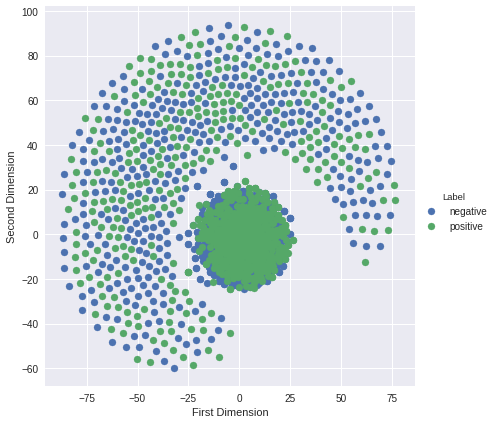

In [47]:
sbn.FacetGrid(df_bow_tsne_3k, hue="Label", size=6).map(plt.scatter, 'First Dimension', 'Second Dimension').add_legend()
plt.show()

The above scatter plot doesn't make any sense. The positive and negative reviews are almost perfectly overlapped. 

This suggests that the Bag of Words model isn't really good at distinguishing between the two types of reviews.

### BoW Bigrams 

This is an extension to the previous model. We consider bi-grams here instead of uni-grams.

First, let's create lists of positive and negative words.

In [0]:
all_positive_words = []

for w in df_p['cleaned_text']:
    all_positive_words.extend(w.split())
#all_positive_words

all_negative_words = []

for w in df_n['cleaned_text']:
    all_negative_words.extend(w.split())
#all_negative_words

Most used words in positive and negative reviews. 

In [49]:
freq_dist_positive = nltk.FreqDist(all_positive_words)
print('Most common positive words: {}'.format(freq_dist_positive.most_common(10)))

freq_dist_negative = nltk.FreqDist(all_negative_words)
print('Most common negative words: {}'.format(freq_dist_negative.most_common(10)))

Most common positive words: [(b'chip', 907), (b'flavor', 728), (b'like', 648), (b'love', 582), (b'great', 567), (b'tast', 552), (b'good', 549), (b'bag', 458), (b'use', 405), (b'one', 404)]
Most common negative words: [(b'tast', 881), (b'like', 847), (b'product', 718), (b'flavor', 551), (b'one', 517), (b'tri', 508), (b'would', 486), (b'use', 417), (b'coffe', 408), (b'good', 389)]


In [0]:
#  Bi-grams
count_vec = CountVectorizer(ngram_range=(1,2))
bigrams = count_vec.fit_transform(df_np['cleaned_text'].values)

The number of bigrams is far more than the unigrams.

In [53]:
bigrams.shape

(3000, 86158)

In [54]:
bigrams

<3000x86158 sparse matrix of type '<class 'numpy.int64'>'
	with 202526 stored elements in Compressed Sparse Row format>

Convert the sparse matrix to a dense numpy matrix.

In [0]:
review_vector_3k = bigrams.toarray()

In [57]:
review_vector_3k.shape

(3000, 86158)

Standardize the data

In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(review_vector_3k)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


At this point, memory is about to run out so let's store the variable on Google drive.

In [0]:
# import pickle
# pickle_file = open('/gdrive/My Drive/amazon/X_scaled_standardized_3k_bigram_bow_nparray.pkl', 'wb')
# pickle.dump(X_scaled, pickle_file)
# pickle_file.close()

Load the pickled X_scaled file.

In [0]:
# import pickle
# file_path = open('/gdrive/My Drive/amazon/X_scaled_standardized_3k_bigram_bow_nparray.pkl', 'rb')
# X_scaled = pickle.load(file_path)

Create a t-SNE model

In [0]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=7, perplexity=40, early_exaggeration = 18, learning_rate = 250, method='exact')

In [0]:
review_vector_3k_tsne = tsne.fit_transform(X_scaled)

Shape of the numpy array after reducing the dimensions to two. 

In [64]:
review_vector_3k_tsne.shape

(3000, 2)

Pickle important variables again.

In [0]:
# # Pickle it first!
# import pickle
# pickle_file = open('/gdrive/My Drive/amazon/pickled_3k_reviews_tsne_bigram.pkl', 'wb')
# pickle.dump(review_vector_3k_tsne, pickle_file)
# pickle_file.close()

Build dataframe

In [0]:
bigram_tsne_3k_array = np.vstack((review_vector_3k_tsne.T, df_np['Score'])).T
df_bigram_tsne_3k = pd.DataFrame(bigram_tsne_3k_array, columns=['First Dimension', 'Second Dimension', 'Label'])

In [67]:
df_bigram_tsne_3k.head()

,First Dimension,Second Dimension,Label
0,-2.51289,-1.45995,negative
1,-1.00926,-4.50503,negative
2,-0.242721,-7.09045,negative
3,1.18093,1.68865,negative
4,1.55271,-1.56169,negative


Plot the result.

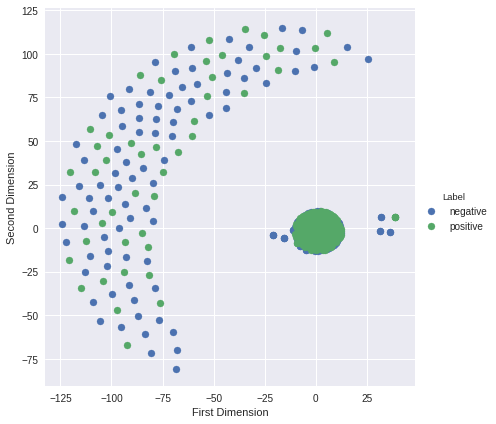

In [68]:
sbn.FacetGrid(df_bigram_tsne_3k, hue="Label", size=6).map(plt.scatter, 'First Dimension', 'Second Dimension').add_legend()
plt.show()

Unfortunately, using bigrams also does not yield anything useful. Let's look at TFIDF next.

### Tfidf

Term Frequency Inverse Document Frequency. 

Let's define the model and fit it to the data.

In [0]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,1))
tfidf = tfidf_vec.fit_transform(df_np['cleaned_text'].values)

In [124]:
tfidf.shape

(3000, 7207)

There are 3000 rows as expected and 7207 dimensions.

In [125]:
features = tfidf_vec.get_feature_names()
len(features)

7207

These are some dimensions in the tfidf representation.

In [75]:
features[100:110]

['age',
 'agent',
 'aggrav',
 'aggress',
 'aggriev',
 'agil',
 'ago',
 'agood',
 'agre',
 'agricultur']

Convert the tfidf matrix to a dense numpy array.

In [128]:
review_vector_3k_TFIDF=tfidf.toarray()
review_vector_3k_TFIDF.shape

(3000, 7207)

Standardize the tfidf data.

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(review_vector_3k)

In [83]:
X_scaled.shape

(3000, 7207)

Apply t-SNE

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=7, perplexity=45, early_exaggeration = 17, learning_rate = 300, method='exact')
review_vector_3k_tsne = tsne.fit_transform(X_scaled)

As expected, the newly create data array has 2 dimensions and 3000 reviews

In [85]:
review_vector_3k_tsne.shape

(3000, 2)

Pickle the tsne object to Google Drive.

In [0]:
import pickle
pickle_file = open('/gdrive/My Drive/amazon/pickled_3k_reviews_tsne_tfidf_1gram.pkl', 'wb')
pickle.dump(review_vector_3k_tsne, pickle_file)
pickle_file.close()

Construct dataframe

In [0]:
tfidf_tsne_3k_array = np.vstack((review_vector_3k_tsne.T, df_np['Score'])).T
df_tfidf_tsne_3k = pd.DataFrame(tfidf_tsne_3k_array, columns=['First Dimension', 'Second Dimension', 'Label'])

In [88]:
df_tfidf_tsne_3k.head()

,First Dimension,Second Dimension,Label
0,-0.0512468,0.11966,negative
1,-7.52004,5.82849,negative
2,14.9827,-10.4608,negative
3,14.8202,-0.939338,negative
4,6.624,-1.51204,negative


Plot the result of applying t-SNE on tfidf.

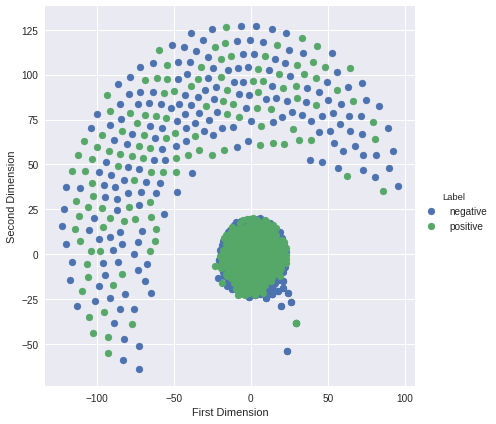

In [89]:
sbn.FacetGrid(df_tfidf_tsne_3k, hue="Label", size=6).map(plt.scatter, 'First Dimension', 'Second Dimension').add_legend()
plt.show()

The TFIDF model too didn't prove to be of much use here. Let's look at a different technique.

### Doc2Vec

In [0]:
# Install gensim if not installed

!pip install gensim

Import gensim

In [0]:
import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors

Define a function that reads each review and converts it into TaggedDocument format needed for training a model using Doc2Vec technique.

In [0]:
#train_corpus = gensim.utils.simple_preprocess(df_np['cleaned_text'][1])

def read_corpus(df_np, tokens_only=False):
        for i, review in enumerate(df_np['cleaned_text']):
            if tokens_only:
                yield gensim.utils.simple_preprocess(review)
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(review), [i])

train_corpus = list(read_corpus(df_np))

In [94]:
train_corpus[:3]

[TaggedDocument(words=['product', 'arriv', 'label', 'jumbo', 'salt', 'peanut', 'peanut', 'actual', 'small', 'size', 'unsalt', 'sure', 'error', 'vendor', 'intend', 'repres', 'product', 'jumbo'], tags=[0]),
 TaggedDocument(words=['look', 'secret', 'ingredi', 'robitussin', 'believ', 'found', 'got', 'addit', 'root', 'beer', 'extract', 'order', 'good', 'made', 'cherri', 'soda', 'flavor', 'medicin'], tags=[1]),
 TaggedDocument(words=['cat', 'happili', 'eat', 'felida', 'platinum', 'two', 'year', 'got', 'new', 'bag', 'shape', 'food', 'differ', 'tri', 'new', 'food', 'first', 'put', 'bowl', 'bowl', 'sit', 'full', 'kitti', 'touch', 'food', 'ive', 'notic', 'similar', 'review', 'relat', 'formula', 'chang', 'past', 'unfortun', 'need', 'find', 'new', 'food', 'cat', 'eat'], tags=[2])]

Define D2V model

In [0]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=45)

Build vocabulary

In [0]:
model.build_vocab(train_corpus)

In [97]:
model

Train D2V model

In [98]:
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 23.1 s, sys: 2.82 s, total: 26 s
Wall time: 14.9 s


Create a corpus of vector representation of all reviews under consideration, using D2V technique.

In [0]:
review_vector_3k = np.zeros((1,50))


for review in df_np['cleaned_text']:
    arr = np.reshape(model.infer_vector(str(review).split()), (1,-1))
    review_vector_3k=np.vstack([review_vector_3k, arr])

#model.infer_vector(str(df_np['cleaned_text'][1636]).split())
#df_np['cleaned_text'][1637]
#df_np['cleaned_text']
#np.reshape(model.infer_vector(str(df_np['cleaned_text'][2]).split()), (1,-1)).shape

review_vector_3k = np.delete(review_vector_3k, (0), axis=0)

A vector is generated that has 3000 rows, each for 1 review and 50 dimensions as defined by the vector_size parameter specified when we defined the model above.

In [100]:
review_vector_3k.shape

(3000, 50)

Standardize the data

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

review_vector_3k = scaler.fit_transform(review_vector_3k)

Define t-SNE and transform data

In [0]:
tsne = TSNE(n_components=2, random_state=7, perplexity=45, early_exaggeration = 13, learning_rate = 300, method='exact')

review_vector_3k_tsne = tsne.fit_transform(review_vector_3k)

As expected, the resulting matrix has 2 dimensions which are created using t-SNE, from the original vector generated using Doc2Vec.

In [103]:
review_vector_3k_tsne.shape

(3000, 2)

Generate a dataframe from it.

In [0]:
d2v_tsne_3k_array = np.vstack((review_vector_3k_tsne.T, df_np['Score'])).T
df_d2v_tsne_3k = pd.DataFrame(d2v_tsne_3k_array, columns=['First Dimension', 'Second Dimension', 'Label'])

In [105]:
df_d2v_tsne_3k.head()

,First Dimension,Second Dimension,Label
0,-11.1299,3.82575,negative
1,6.52225,-12.4862,negative
2,15.491,23.387,negative
3,8.68189,6.55631,negative
4,-8.87508,-0.928835,negative


Plot the result.

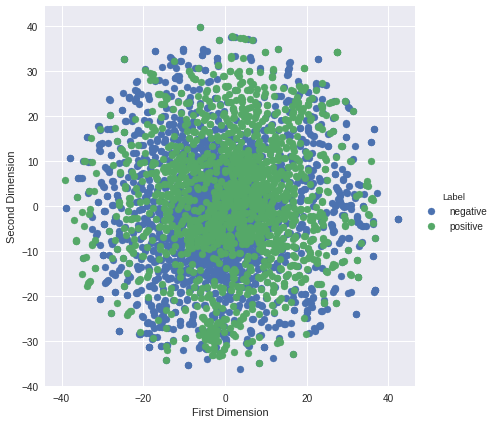

In [106]:
sbn.FacetGrid(df_d2v_tsne_3k, hue="Label", size=6).map(plt.scatter, 'First Dimension', 'Second Dimension').add_legend()
plt.show()

Not much here, either.

### Word2Vec

In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

Here, I'm training the model using our own corpus of food reviews. The reason behind not using Google's model trained on google news is - there are several words used in the food reviews that aren't present in the model trained by Google. Creating vectors of reviews using it throws exceptions. 

In [0]:
# Training a Word2Vec model using our own corpus

list_of_reviews = []

for review in df['cleaned_text'].values:
    list_of_reviews.append(review.decode('utf-8').split())

In [109]:
print(df['cleaned_text'][0])
print('------------------')
print(list_of_reviews[0])


b'bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better'
------------------
['bought', 'sever', 'vital', 'can', 'dog', 'food', 'product', 'found', 'good', 'qualiti', 'product', 'look', 'like', 'stew', 'process', 'meat', 'smell', 'better', 'labrador', 'finicki', 'appreci', 'product', 'better']


In [0]:
w2v_model = gensim.models.Word2Vec(list_of_reviews, min_count=4,size=50,workers=4)

In [111]:
words = list(w2v_model.wv.vocab)
print(len(words))

24867


The following result is fascinating. It shows the words which are similar to 'smell'. The list of words printed is amazing.

In [112]:
w2v_model.wv.most_similar('smell')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('scent', 0.7834073901176453),
 ('smelt', 0.7453423738479614),
 ('odor', 0.7058023810386658),
 ('perfum', 0.6976401805877686),
 ('fragranc', 0.6837777495384216),
 ('stink', 0.6754734516143799),
 ('musti', 0.6711809635162354),
 ('aroma', 0.6633960604667664),
 ('offens', 0.6588740348815918),
 ('whiff', 0.6521865129470825)]

Similarly, words similar to 'bad'

In [113]:
w2v_model.wv.most_similar('bad')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('terribl', 0.7701851725578308),
 ('okay', 0.7428017854690552),
 ('horribl', 0.731977105140686),
 ('aw', 0.7248077392578125),
 ('nasti', 0.7048215270042419),
 ('weird', 0.69244384765625),
 ('gross', 0.6909690499305725),
 ('alright', 0.689479649066925),
 ('funni', 0.6816542148590088),
 ('odd', 0.6704462170600891)]

Calculating the avg W2V representation for each review.

In [0]:
import sys

corpus_vec = np.zeros(shape=(50))

for review in df_np['cleaned_text'].values:
    review_vector = np.zeros(shape=(50))
    for word in review.decode('utf-8').split():
        try:
            
            review_vector += w2v_model.wv[word]
            
        except KeyError:
            continue
    
    review_vector /= 50
    corpus_vec=np.vstack((corpus_vec,review_vector))    
corpus_vec=np.delete(corpus_vec, 0, axis=0)

In [116]:
corpus_vec.shape

(3000, 50)

Again, store the files on Google Drive for future use.

In [0]:
import pickle
pickle_file = open('/gdrive/My Drive/amazon/avg_w2v_nparray_3kcorpus_50dim.pkl', 'wb')
pickle.dump(corpus_vec, pickle_file)
pickle_file.close()

In [118]:
corpus_vec.shape

(3000, 50)

Appply t-SNE

In [0]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=7, perplexity=45, early_exaggeration = 13, learning_rate = 250)

review_vector_3k_tsne = tsne.fit_transform(corpus_vec)

In [120]:
review_vector_3k_tsne.shape

(3000, 2)

Build a dataframe for visualization

In [0]:
avg_w2v_tsne_3k_array = np.vstack((review_vector_3k_tsne.T, df_np['Score'])).T
df_avg_w2v_tsne_3k = pd.DataFrame(avg_w2v_tsne_3k_array, columns=['First Dimension', 'Second Dimension', 'Label'])

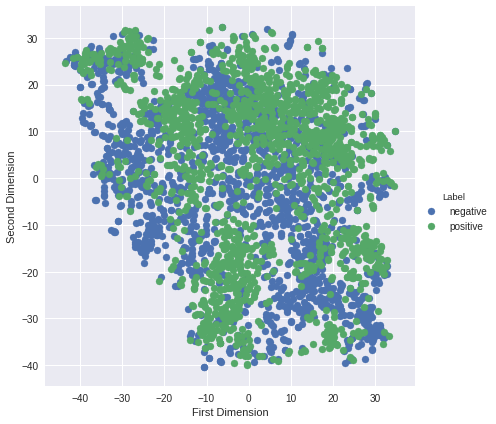

In [122]:
sbn.FacetGrid(df_avg_w2v_tsne_3k, hue="Label", size=6).map(plt.scatter, 'First Dimension', 'Second Dimension').add_legend()
plt.show()

The above result is far from ideal, but it's slightly better than the techniques seen so far. The density of positive points is more in the right side of the map as compared to the left side.

### Tfidf weighted W2V

In this representation, each review is made up from the tfidf weighted sum of all the words in a review.

In [0]:
corpus_tfidf_weighted_w2v = np.zeros(shape=(50))
review_number = 0

for review in df_np['cleaned_text'].values:
    review_vector_tfidf_weighted = np.zeros(shape=(50))
    tfidf_sum = 0
    for word in review.decode('utf-8').split():
        try:
            tfidf_value = review_vector_3k_TFIDF[review_number, features.index(word)]
            review_vector_tfidf_weighted += w2v_model.wv[word] * tfidf_value
            tfidf_sum += tfidf_value
            
        except KeyError:
            continue
    
    review_number += 1
    
    review_vector_tfidf_weighted /= tfidf_sum
    corpus_tfidf_weighted_w2v=np.vstack((corpus_tfidf_weighted_w2v,review_vector_tfidf_weighted))
    
corpus_tfidf_weighted_w2v = np.delete(corpus_tfidf_weighted_w2v, 0, axis=0)

Shape of the data matrix

In [132]:
corpus_tfidf_weighted_w2v.shape

(3000, 50)

Apply t-SNE 

In [0]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=13, perplexity=50, early_exaggeration = 14, learning_rate = 225)

review_vector_3k_tsne = tsne.fit_transform(corpus_tfidf_weighted_w2v)

The dimensions of the array reduced to 2 as expected.

In [134]:
review_vector_3k_tsne.shape

(3000, 2)

Build a dataframe.

In [0]:
avg_tfidf_weighted_w2v_tsne_3k_array = np.vstack((review_vector_3k_tsne.T, df_np['Score'])).T
df_avg_tfidf_weighted_w2v_tsne_3k = pd.DataFrame(avg_tfidf_weighted_w2v_tsne_3k_array, columns=['First Dimension', 'Second Dimension', 'Label'])

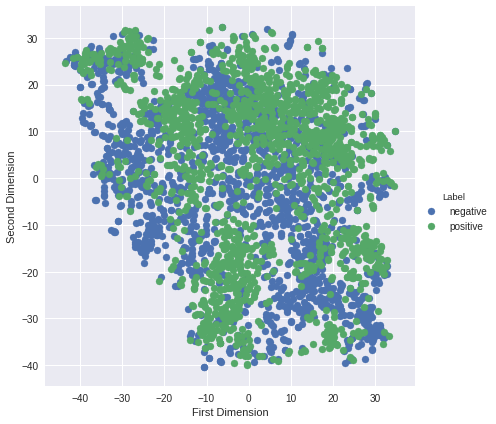

In [136]:
sbn.FacetGrid(df_avg_w2v_tsne_3k, hue="Label", size=6).map(plt.scatter, 'First Dimension', 'Second Dimension').add_legend()
plt.show()

The tfidf weighted W2V plot is not very different from the plot obtained using the avg. W2V representation. 

TFIDF values of words in a review

In [130]:
review = 414

for word in df_np['cleaned_text'][review].decode('utf-8').split():
    
    print('{} : {}'.format(word, tfidf[review, features.index(word)]))

chip : 0.0
right : 0.0
amount : 0.0
crunch : 0.0
enjoy : 0.0
tast : 0.11877744889822464
chip : 0.0
consist : 0.1376015524136066
fairli : 0.0
even : 0.0
distribut : 0.0
season : 0.0
like : 0.11664406503962119
size : 0.0
bag : 0.0
right : 0.0
amount : 0.0
chip : 0.0


## Conclusion

In this exercise, I achieved the following goals:

* Cleaning dirty data. 
            The original food reviews dataset contains lots of duplicate entries and HTML tags.
* Vector representation of text using techniques such as 
            Bag Of Words (unigram & bigram), Tfidf, Doc2Vec, Avg. W2V, Tfidf weighted W2V
            
* Applying t-SNE on text data, which are represented in the form of vectors to reduce dimensions from hundreds to just two.

* The cluster seperation may be improved by using larger amount of data. Due to limitations of hardware, I used just 3000 reviews in the dataset which is about 0.57% the size of the original dataset.